<table style="width: 100%;" id="nb-header">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Fall 2022<br>
            Dr. Eric Van Dusen <br>
        Alan Liang <br>
            Umar Maniku<br>
            Matthew Yep<br>
            Yiyang Chen <br>
            Bennett Somerville <br>
</table>

# Lecture 10: Macroeconomics Policy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datascience import * 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.optimize import curve_fit
import math
from math import *
import seaborn as sns
import itertools
%matplotlib inline

**Learning Objectives:**  
In this notebook, we will download macroeconomic data and examine how the models and theories we discussed in lecture fit with these real life data. This notebook will introduce the basic concept of an API, the way to use it for economic research and study. 

## Macroeconomic Data and Fred API

We will start by first download some macroeconomic data from FRED. In this notebook, we will introduce two ways of interacting with online sources of data with API (Application Programming Interface).  

**What is an API?**  
In contrast to a user interface, which connects a computer to a person, an application programming interface (API) connects computers or pieces of software to each other. It is not intended to be used directly by a person (the end user) other than a computer programmer who is incorporating it into the software. An API is often made up of different parts which act as tools or services that are available to the programmer. A program or a programmer that uses one of these parts is said to call that portion of the API. The calls that make up the API are also known as subroutines, methods, requests, or endpoints. An API specification defines these calls, meaning that it explains how to use or implement them. 

In basic terms, APIs just allow applications to communicate with one another. For the APIs we are concerned right now--web based APIs that return data in response to a request made by us--**they allow us to get data from outside sources by sending an API a request detailing the information we want. Then the API will "respond" with the requested data to us.**

<img src="images/what_is_an_API.png" alt="What is an API" style="width:600px;height:200px;">
<center>Source: Perry Eising, "What exactly is an API?"</center>

### General Way of Interacting with an API

First, we will use the most common way to access the data through an API without using any packages other may have already built for a particular site. Usually this is the way you would interact with an API.  

#### Step 1: Get the API Key
**In most cases, you will need to get an API key in order to access an API.** For many resources, it involves some paperwork to apply and/or limited free usage, so it is good practice to keep your API keys private as long as it is possible. In this lecture notebook, we will use macroeconomic data from FRED, which is one of the most famous and convenient sources of economic data. For FRED, the process of getting an API key is simple. Request the API key [here](https://fred.stlouisfed.org/docs/api/api_key.html). 

In [2]:
# For demo purposes, we are leaving our API key here. You should always try to avoid this. 
api_key = "dab081fe5e028d7fc65114e0c7f2cf6b"

#### Step 2: Learn to use the API
Using an API is like ordering food at a restaurant with a menu. To have a delicious meal, we have to know what food the restaurant offers, and any other additional information (for example, how would you like your steak). Similarly, it is very important for us to know what requests an API take through the API documentation. **The API documentation will inform us about how we can use specific instructions to obtain the data that we want, and what the returned data would look like.** Look up the Fred API's documentation [here](https://fred.stlouisfed.org/docs/api/fred/series_observations.html). 


<div class="alert alert-info">
<b> Example: "api.stlouisfed.org/fred/series/observations?series_id=GNPCA&api_key=abcdefghijklmnopqrstuvwxyz123456" <br>  
  
Endpoint: "api.stlouisfed.org/fred/series/observations"  <br>
Parameters: series_id=GNPCA, api_key=abcdefghijklmnopqrstuvwxyz123456
</div>

Try the following link to see what the API will return!   

https://api.stlouisfed.org/fred/series/observations?series_id=GNPCA&api_key=dab081fe5e028d7fc65114e0c7f2cf6b&file_type=json

#### Step 3: Make the fetch
Now we are ready to start writing code to fetch the data we want through the API. 

In [3]:
import requests
from urllib.parse import urlencode
endpoint = "https://api.stlouisfed.org/fred/series/observations"

Parameters that we would like to include in our query (these can be found in the FRED API documentations!):  
- "series_id": The Economic data series we want (e.g. GDP)
- "observation_start": The earliest date we want our data to include
- "observation_end": The latest date we want our data to include
- "frequency": The frequency of observations (e.g. Annually, Quarterly, Monthly)
- "units": The units of observations (e.g. plain numbers, percentage change from a year ago, etc.)
- "api_key": The API key
- "file_type": The file data that will returned from FRED (e.g. json, xml)

In [4]:
def fetch(series_id, unit="lin"):
    # specifies parameters
    params = {"series_id": series_id, 
              "observation_start": "1958-01-01", 
              "observation_end": "2021-10-01",
              "frequency": "q", # quarterly
              "units": unit,
              "api_key": api_key, 
              "file_type": "json"
             }
    
    # forms API request
    url_params = urlencode(params)
    url = f"{endpoint}?{url_params}"
    
    # fires off the request
    res = requests.get(url)
    
    # checks if the request encounters an error
    if res.status_code not in range(200, 299):
        raise Exception(f'Fetch request for "{series_id}" failed (Error: {res.status_code})')
    
    # return the content of the response
    return res.json()

Let's try downloading the real GDP data from Fred now. 

In [5]:
res_json_GDP = fetch("GDPC1")
#res_json_GDP

In [6]:
# process the response
gdp = pd.DataFrame(res_json_GDP["observations"])[["date", "value"]]
gdp.rename(columns={"value": "GDP"}, inplace=True)
gdp.head()

,date,GDP
0,1958-01-01,2908.281
1,1958-04-01,2927.395
2,1958-07-01,2995.112
3,1958-10-01,3065.141
4,1959-01-01,3123.978


**Congratulations! We have just made our first request to Fred API and obtain some useful data.**  

Now let's try download more macroeconomic indicators.

In [7]:
# this function allows us to fetch and process the data together
def fetch_and_process(series_id, unit="lin"):
    res_json = fetch(series_id, unit)
    return pd.DataFrame(res_json["observations"])[["date", "value"]].rename(columns={"date":"DATE", "value": f"{series_id}_{unit}"})

In [8]:
gdp = fetch_and_process("GDPC1")
gdp_growth = fetch_and_process("GDPC1", "pc1")
inflation = fetch_and_process("CPIAUCSL", "pc1")
unemployment = fetch_and_process("UNRATE")
ffr = fetch_and_process("DFF")
nrou = fetch_and_process("NROU")
core_inflation = fetch_and_process("CPILFESL", "pc1")

In [9]:
gdp_growth.head()

,DATE,GDPC1_pc1
0,1958-01-01,-2.87143
1,1958-04-01,-2.01841
2,1958-07-01,-0.72480
3,1958-10-01,2.65814
4,1959-01-01,7.41665


### Site-Specific Prebuilt Packages

Now we will switch gears to use some prebuilt packages to access FRED API. Notice that the prebuilt packages are not necessarily available for every API. But here we will use the "FredAPI" package developed by Mortada Mehyar. Documentation [here](https://github.com/mortada/fredapi). 

In [10]:
# may need to install the package and its dependencies
from fredapi import Fred
fred = Fred(api_key=api_key)
GDP_fredapi = pd.DataFrame(fred.get_series('GDP'))
GDP_fredapi.head(10)

,0
1946-01-01,NaN
1946-04-01,NaN
1946-07-01,NaN
1946-10-01,NaN
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
1948-04-01,272.567


You will get more practive with FREDAPI package in the lab!

### Other Methods
Some sites also provides a client to access their APIs with ease. 

## Macroeconomic Indicators and Data

**Now we're off to use the data we have just got!**

In [11]:
# we will also read in some additional data
deficit = pd.read_csv("deficit_over_time.csv")
potential_gdp = pd.read_csv("potential_gdp.csv")
unemployment_gap = pd.read_csv("nrou.csv")
core_inflation["CPILFESL_pc1"] = core_inflation["CPILFESL_pc1"].apply(lambda item: np.round(float(item), 2))

# merge all macroeconomic data we have got!
macroeconomics = gdp.merge(gdp_growth)\
                    .merge(inflation)\
                    .merge(unemployment)\
                    .merge(ffr)\
                    .merge(core_inflation)\
                    .merge(unemployment_gap)\

macroeconomics = macroeconomics.set_index("DATE").apply(pd.to_numeric).reset_index("DATE")

potential_gdp = potential_gdp[potential_gdp["DATE"] <= max(macroeconomics["DATE"])]

In [12]:
macroeconomics.head()

,DATE,GDPC1_lin,GDPC1_pc1,CPIAUCSL_pc1,UNRATE_lin,DFF_lin,CPILFESL_pc1,NROU
0,1958-01-01,2908.281,-2.87143,3.45614,6.3,1.87,2.80,5.414240
1,1958-04-01,2927.395,-2.01841,3.27225,7.4,0.94,2.43,5.418266
2,1958-07-01,2995.112,-0.72480,2.29980,7.3,1.32,2.07,5.422658
3,1958-10-01,3065.141,2.65814,1.91315,6.4,2.16,1.82,5.427429
4,1959-01-01,3123.978,7.41665,0.89317,5.8,2.58,1.81,5.432577


---

### Macroeconomics Indicators and their Time Series
In this section, we will see how the value of each macroeconomic indicator varied from 1958 to present. 

In [13]:
series_names = {"GDPC1_lin": "GDP", 
               "GDPC1_pc1": "GDP Growth", 
               "CPIAUCSL_pc1": "Inflation", 
               "UNRATE_lin": "Unemployment Rate", 
               "DFF_lin": "Fed Funds Rate", 
               "CPILFESL_pc1": "Core Inflation Rate", 
               "NROU": "Noncyclical Rate of Unemployment" # aka NAIRU, Natural Rate of Unemployment (Long-term)
              }

# generate a time series plot for "series"
def plot_time_series(data, series, title="1958 to present", figsize=(14, 8)):
    
    plt.figure(figsize=figsize)
    
    plt.plot(data["DATE"], data[series])
    
    # plot a horizontal line at zero if the variable is in percent
    if ("pc1" in series):
        plt.axhline(y=0, color='black', linestyle='-.')
    
    plt.xticks(data.index[np.arange(0, data.shape[0], 16)], rotation=45)
    plt.grid(visible=True)
    
    plt.xlabel("DATE")
    plt.ylabel(series)
    plt.title(f"{series_names[series]}: {title}", fontsize=16)

#### GDP

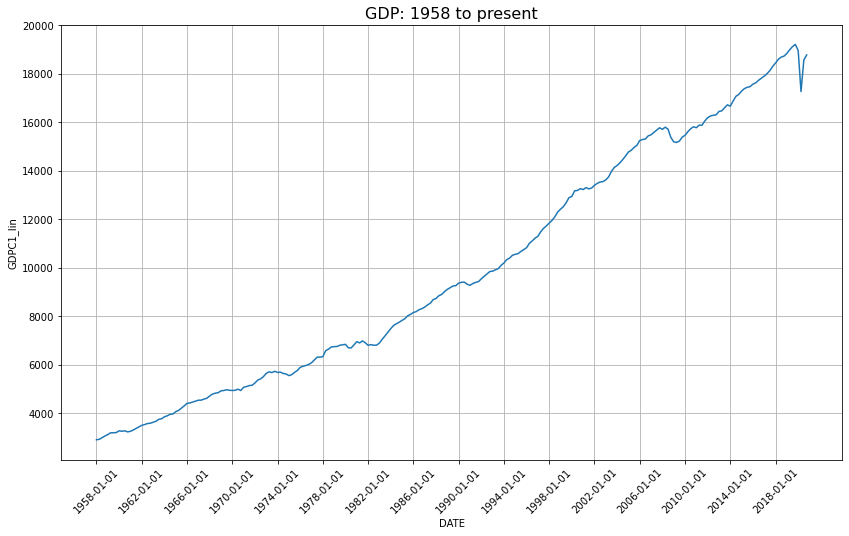

In [14]:
plot_time_series(macroeconomics, "GDPC1_lin")

#### GDP Growth

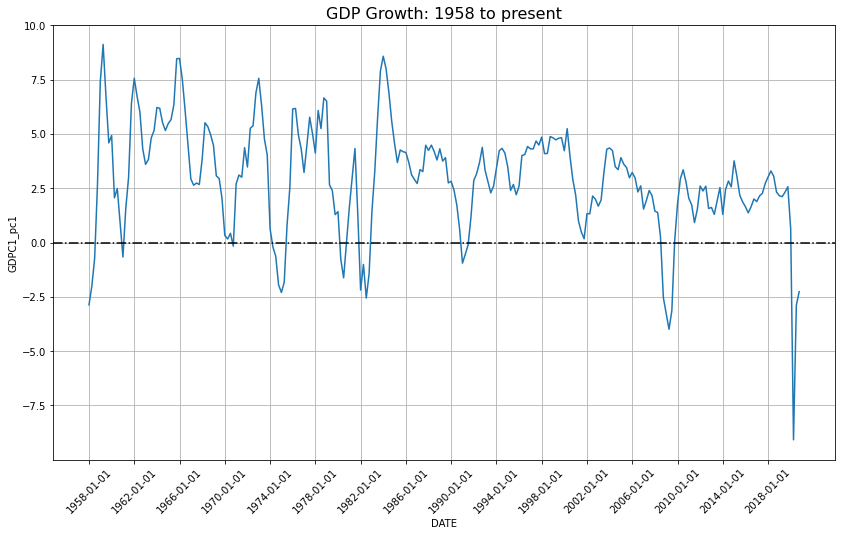

In [15]:
plot_time_series(macroeconomics, "GDPC1_pc1")

#### Inflation Rate

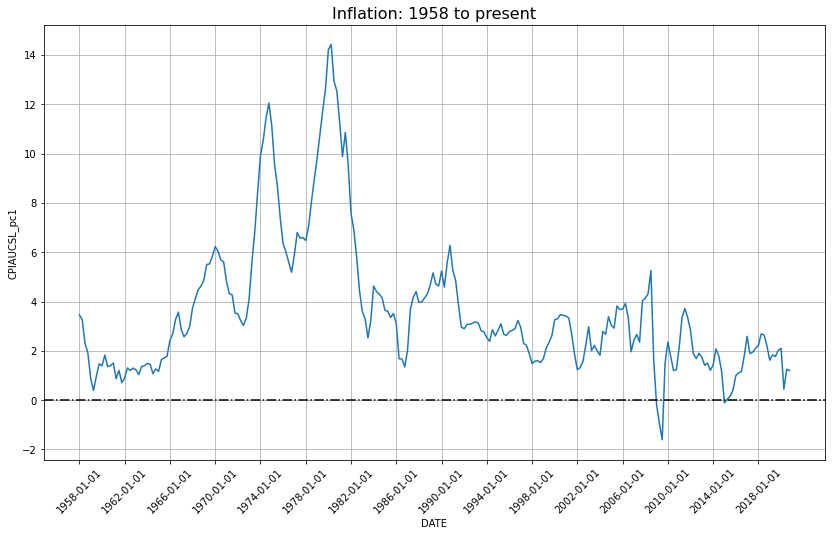

In [16]:
plot_time_series(macroeconomics, "CPIAUCSL_pc1")

#### Core Inflation Rate

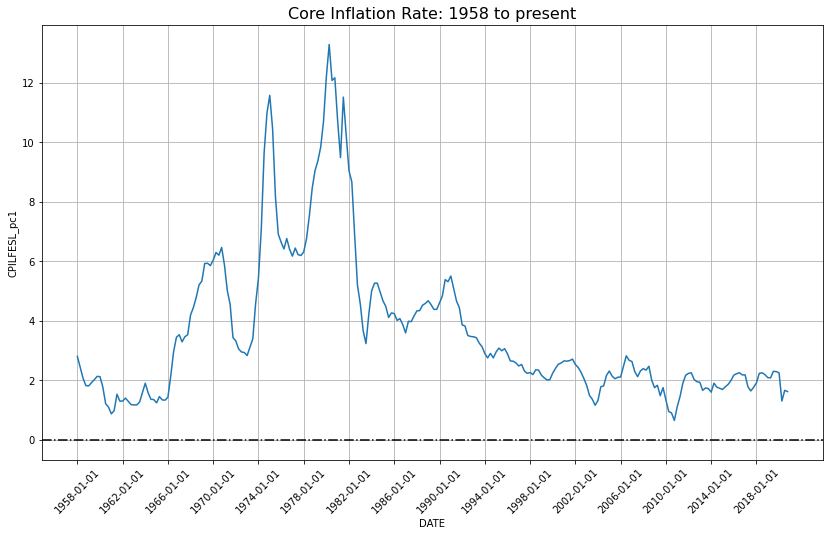

In [17]:
plot_time_series(macroeconomics, "CPILFESL_pc1")

#### Unemployment Rate

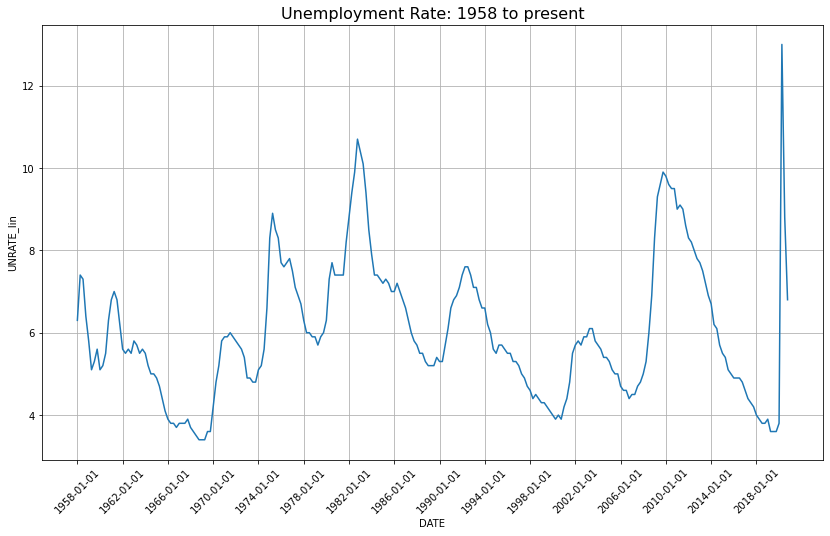

In [18]:
plot_time_series(macroeconomics, "UNRATE_lin")

#### Fed Funds Rate

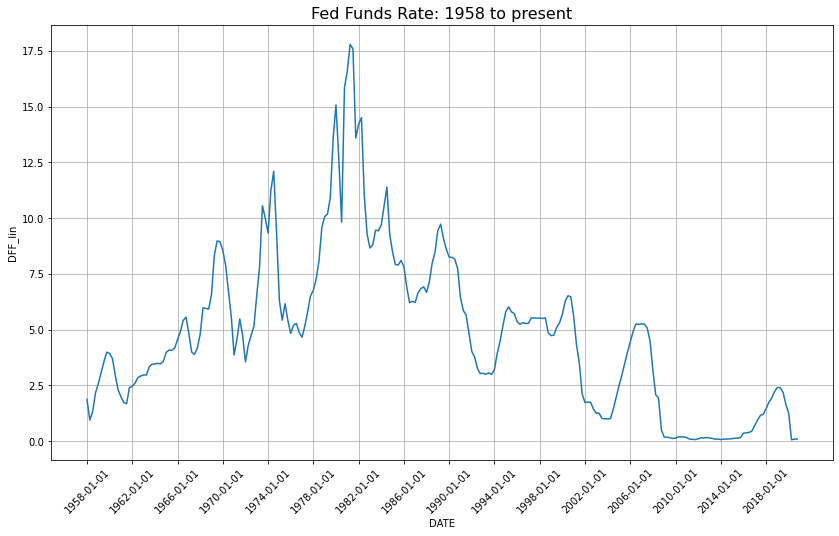

In [19]:
plot_time_series(macroeconomics, "DFF_lin")

#### Noncyclical Rate of Unemployment

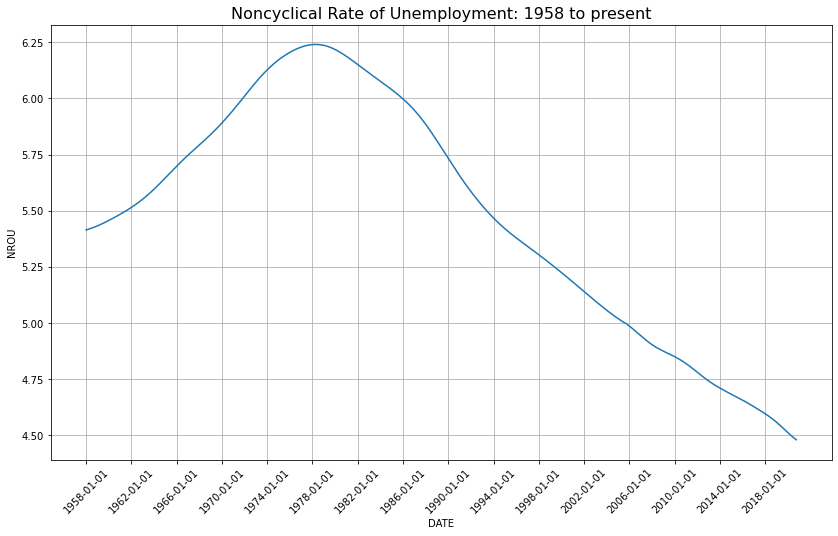

In [20]:
plot_time_series(macroeconomics, "NROU")

What interesting pattern do you notice?

### Macroeconomic Indicators during the COVID-19 Pandemic

In [21]:
covid = macroeconomics[macroeconomics["DATE"] >= "2019-01-01"]
covid_deficit = deficit[deficit["DATE"] >= "2019-01-01"]
covid_potential_gdp = potential_gdp[potential_gdp["DATE"] >= "2019-01-01"]
covid_ffr = ffr[ffr["DATE"] >= "2019-01-01"]

In [22]:
def plot_covid(series):
    plot_time_series(covid, series, title="During COVID", figsize=(9, 6))

In [23]:
v = widgets.Dropdown(
    options=['GDPC1_lin', 'GDPC1_pc1', 'CPIAUCSL_pc1', 'UNRATE_lin', 'DFF_lin', 'CPILFESL_pc1', 'NROU'],
    value='GDPC1_lin',
    description='Indicator:',
    disabled=False
)

interact(plot_covid, series=v);

interactive(children=(Dropdown(description='Indicator:', options=('GDPC1_lin', 'GDPC1_pc1', 'CPIAUCSL_pc1', 'U…

## Phillips Curve
Phillips Curve describes a negative relationship between inflation and unemployment. 

$$ \pi = - f(u)$$

where $\pi$ is the inflation rate, $u$ is the unemployment rate. 

**Let's first create a dataframe with relevant data, i.e. inflation rate and unemployment rate.**

In [24]:
phillips_curve = macroeconomics[["DATE", "UNRATE_lin", "CPILFESL_pc1", "NROU"]].copy()
phillips_curve["decade"] = phillips_curve["DATE"].apply(lambda date: int(date[:4]) // 10 * 10)
phillips_curve.set_index("DATE", inplace=True)
phillips_curve = phillips_curve.apply(pd.to_numeric)
phillips_curve.head()

,UNRATE_lin,CPILFESL_pc1,NROU,decade
DATE,,,,
1958-01-01,6.3,2.80,5.414240,1950
1958-04-01,7.4,2.43,5.418266,1950
1958-07-01,7.3,2.07,5.422658,1950
1958-10-01,6.4,1.82,5.427429,1950
1959-01-01,5.8,1.81,5.432577,1950


Friendly note: you should not use this piece of code for your lab, because the dataframe is slightly different!

### Empirical Relationship

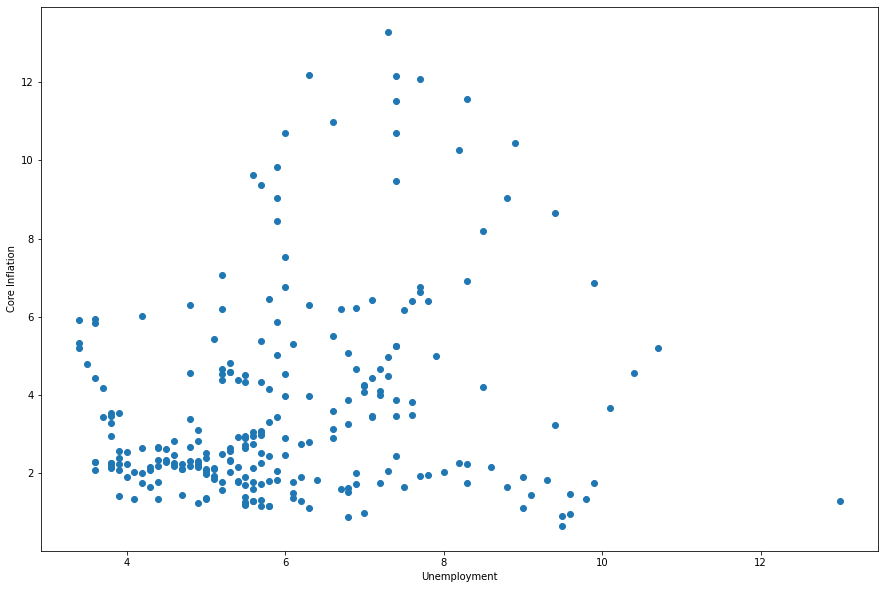

In [25]:
plt.figure(figsize=(15, 10))
plt.scatter(x=phillips_curve["UNRATE_lin"], y=phillips_curve["CPILFESL_pc1"])
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.show()

**Now we will try a fit a curve to the empirical data of unemployment and core inflation.** 

In [26]:
unique_vals = pd.DataFrame([[k,v.values] for k,v in phillips_curve.groupby('UNRATE_lin').groups.items()], 
                      columns=['UNRATE_lin','indices'])
unique_vals["indices"] = unique_vals["indices"].apply(lambda item: item[0])
unique_vals["CPILFESL_pc1"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "CPILFESL_pc1"])
unique_vals["NROU"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "NROU"])
unique_vals["decade"] = unique_vals["indices"].apply(lambda item: phillips_curve.loc[item, "decade"])
unique_vals.set_index("indices", inplace=True)
unique_vals.head()

,UNRATE_lin,CPILFESL_pc1,NROU,decade
indices,,,,
1968-10-01,3.4,5.20,5.826905,1960
1968-07-01,3.5,4.78,5.815176,1960
1968-04-01,3.6,4.44,5.803658,1960
1966-10-01,3.7,3.44,5.734915,1960
1966-04-01,3.8,2.14,5.710529,1960


In [27]:
def aesthetic_pc(x, a):
    return a / x

In [28]:
popt, _ = curve_fit(aesthetic_pc, unique_vals["UNRATE_lin"], unique_vals["CPILFESL_pc1"])

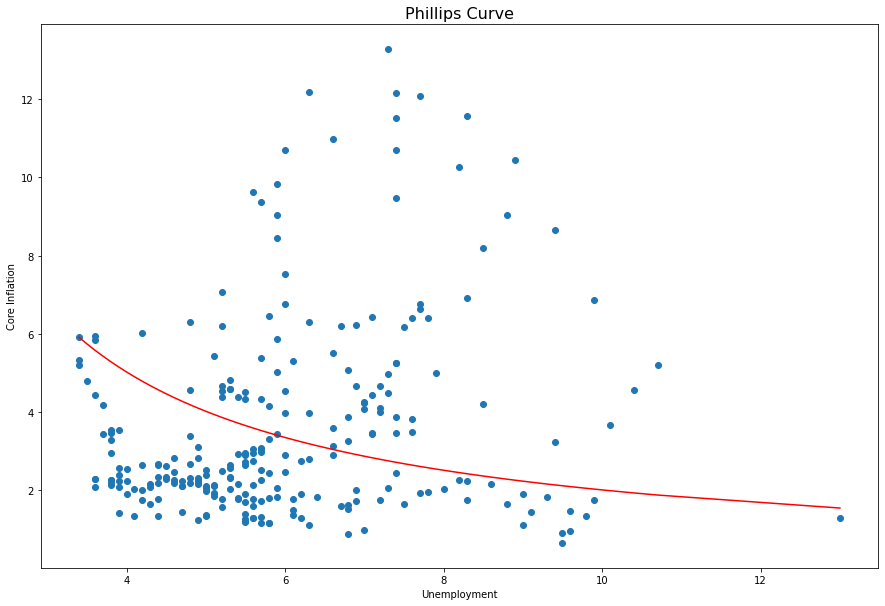

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(unique_vals["UNRATE_lin"], aesthetic_pc(unique_vals["UNRATE_lin"], *popt), color="red")
plt.scatter(x=phillips_curve["UNRATE_lin"], y=phillips_curve["CPILFESL_pc1"])
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.title("Phillips Curve", fontsize=16)
plt.show()

### Empirical Relationship Overtime
How does the empirical Phillips Curve change over time?

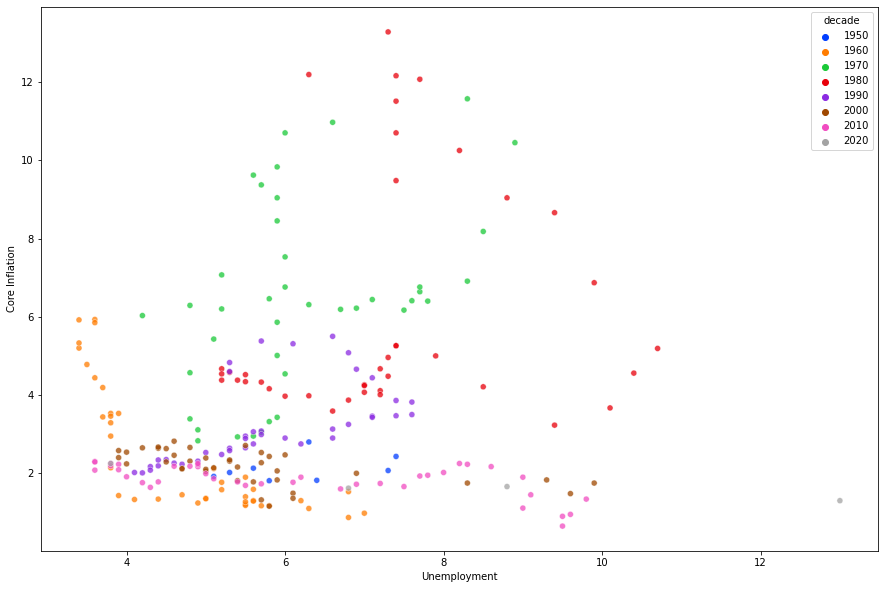

In [30]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x="UNRATE_lin", y="CPILFESL_pc1", data=phillips_curve, 
                hue="decade", palette="bright", alpha=0.75)
plt.xlabel("Unemployment")
plt.ylabel("Core Inflation")
plt.show()

To show this more clearly, try toggling the widgets!

In [31]:
def plot_subset(start, length):
    start_str = str(start) + "-01-01"
    end_str = str(start + length) + "-01-01"
    
    subset = phillips_curve[(phillips_curve.index >= start_str) & (phillips_curve.index <= end_str)]
    
    plt.figure(figsize=(12, 8))
    plt.scatter(subset["UNRATE_lin"], subset["CPILFESL_pc1"])
    plt.xlim(3, 10)
    plt.ylim(0, 12)
    plt.xlabel("Unemployment Rate", fontsize=16)
    plt.ylabel("Inflation Rate", fontsize=16)
    plt.title(f"Time Period: {start} - {start + length}", fontsize=16)

l = widgets.RadioButtons(
    options=[5, 10, 20],
    value=5,
    description='Length:',
    disabled=False
)
s = widgets.IntSlider(min=1960, max=2020-l.value, step=2)

interact(plot_subset, start=s, length=l);

interactive(children=(IntSlider(value=1960, description='start', max=2015, min=1960, step=2), RadioButtons(des…

<div class="alert alert-info">
<b> What do you notice about the relationship between unemployment and inflation over time?
</div>

---

## Taylor Rule

The Taylor Rule was first proposed in 1993 by the American economist John B. Taylor. It’s called a “rule” because it serves as a guide to monetary policy for how to set interest rates based on the inflation gap and output gap at a given time. The equation is as follows  

$$
r_{\text{predicted}} = r_{\text{target}} + \pi + \alpha \left ( \pi - \pi_{\text{target}} \right ) + \beta \left ( \dfrac{Y - Y^*}{Y^*} \right )
$$

where $r$ is the interest rate, $\pi$ is the inflation rate, and $Y$ is the economic output. $\alpha$ and $\beta$ are two parameters we can change to make the predictions from Taylor Rule more accurate. In the "classical" Taylor Rule, we set $\alpha$ and $\beta$ to be both $0.5$. This is what we will do next. 

In [32]:
def taylor_rule(interest_rate_target, inflation, inflation_target, output, potential_output, alpha=0.5, beta=0.5):
    return interest_rate_target + inflation + alpha * (inflation - inflation_target) + \
            beta * ((output - potential_output) / potential_output) * 100

In [33]:
def taylor_rule_plotter(arr, ffr_arr=None, label=None):
    plt.figure(figsize=(17, 9))
    if ffr_arr is not None:
        plt.plot(ffr_arr, label="FFR")
        plt.xticks(np.arange(0, ffr_arr.shape[0]), rotation = 45)
    else:
        plt.plot(macroeconomics["DATE"], macroeconomics["DFF_lin"], label="FFR")
        plt.xticks(np.arange(0, ffr.shape[0], 20), rotation = 45)
    plt.plot(arr, label=label)
    plt.legend()
    plt.grid()
    plt.axhline(color="black", linestyle="-.")
    plt.title("Empirical Evidence of the Taylor Rule", fontsize=16)
    plt.show();

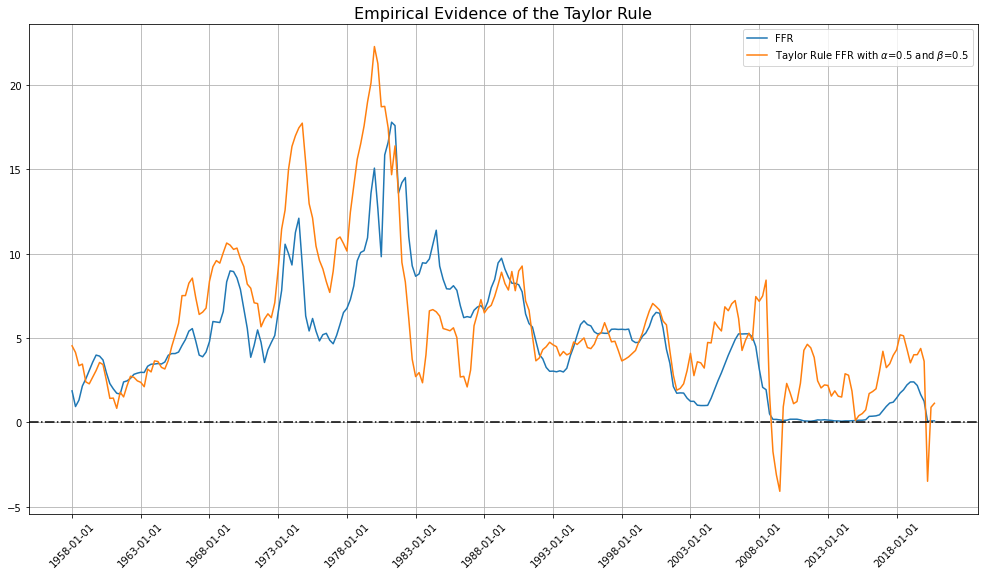

In [34]:
# "CPIAUCSL_pc1" is the inflation rate, "GDPC1_lin" is GDP
taylor_rule_preds = taylor_rule(2, macroeconomics.loc[:, "CPIAUCSL_pc1"], 2, 
                                macroeconomics.loc[:, "GDPC1_lin"], potential_gdp.loc[:, "GDPPOT"])

taylor_rule_plotter(taylor_rule_preds, label=r"Taylor Rule FFR with $\alpha$=0.5 and $\beta$=0.5")

As we can see, the predictions from the Taylor Rule generally follow very closely with the actual Federal Funds rate. 

### The Taylor Rule during the COVID-19 Pandemic

How did the Taylor Rule hold during the COVID-19 pandemic, where the U.S. economy (also worldwide) was confronted with a huge ruduction of economic output. 

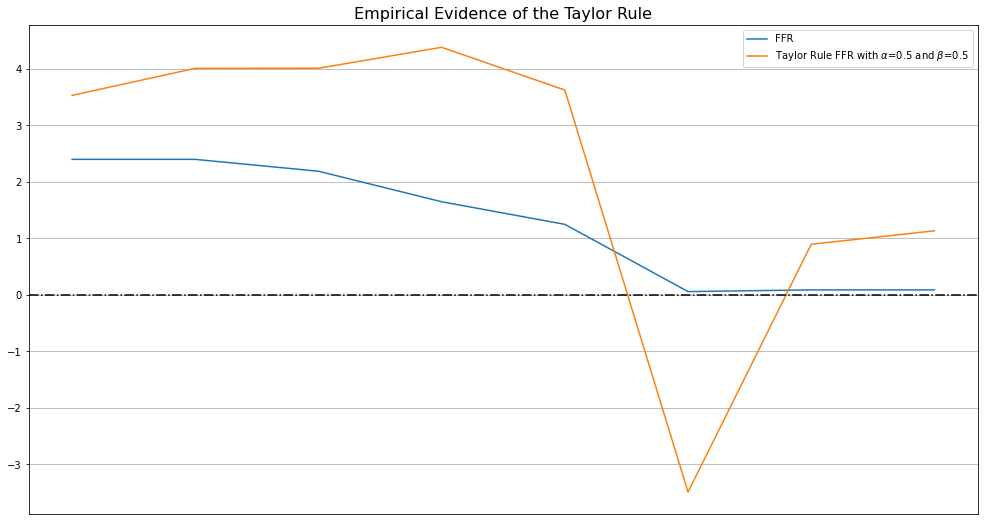

In [35]:
taylor_rule_preds_covid = taylor_rule(2, covid["CPIAUCSL_pc1"], 2, 
                                covid["GDPC1_lin"], covid_potential_gdp["GDPPOT"])

taylor_rule_plotter(taylor_rule_preds_covid, ffr_arr=covid.loc[:, "DFF_lin"], 
                    label=r"Taylor Rule FFR with $\alpha$=0.5 and $\beta$=0.5")

It turns out the Taylor Rule predicts a much lower interest rate than the actual interest rate set by the Federal Reserve. One of the obvious reason for this difference is that the Federal Reserve cannot set a nominal interest rate below zero. 

### Best Parameters for Taylor Rule

Now we will find what the set of $\alpha$ and $\beta$ that can best approximate the actual Federal Funds Rate using the Taylor Rule.  
Again recall the Taylor Rule: 
$$
r_{\text{predicted}} = r_{\text{target}} + \pi + \alpha \left ( \pi - \pi_{\text{target}} \right ) + \beta \left ( \dfrac{Y - Y^*}{Y^*} \right )
$$

In [36]:
def taylor_rmse(alpha, beta):
    taylor_interest_rate = np.array(taylor_rule(2, macroeconomics["CPIAUCSL_pc1"], 2, 
                                                macroeconomics["GDPC1_lin"], potential_gdp["GDPPOT"], 
                                                alpha = alpha, beta = beta))
    actual_interest_rate = np.array(macroeconomics["DFF_lin"])
    return np.mean(((taylor_interest_rate - actual_interest_rate) ** 2))

In [37]:
def taylor_widget(alpha, beta):
    rmse = taylor_rmse(alpha, beta)
    print(f"RMSE: {rmse}")
    taylor_rule_preds = taylor_rule(2, macroeconomics["CPIAUCSL_pc1"], 2, 
                                macroeconomics["GDPC1_lin"], potential_gdp["GDPPOT"], 
                                    alpha=alpha, beta=beta)
    taylor_rule_plotter(taylor_rule_preds, 
                        label=rf"Taylor Rule FFR with $\alpha$={alpha} and $\beta$={beta}");

Try toggling the sliders, and see if you can find a pair of $\alpha$ and $\beta$ that minimizes the RMSE!

In [38]:
alpha_widget = widgets.FloatSlider(min=-1, max=2, step=0.1, value=0.5)
beta_widget = widgets.FloatSlider(min=-1, max=2, step=0.1, value=0.5)
interact(taylor_widget, alpha=alpha_widget, beta=beta_widget);

interactive(children=(FloatSlider(value=0.5, description='alpha', max=2.0, min=-1.0), FloatSlider(value=0.5, d…

### Optimizing for $\alpha$, $\beta$
This time we will let the algorithm to optimize $\alpha$ and $\beta$ for us. Compare the results and see what you can find! 

In [39]:
alpha, beta = minimize(taylor_rmse)
print(f"RMSE using optimized parameters: {taylor_rmse(alpha, beta)}")
print(f"alpha: {alpha}, beta: {beta}")

RMSE using optimized parameters: 5.463077446123714
alpha: -0.090923032996619, beta: 0.23675524709176723


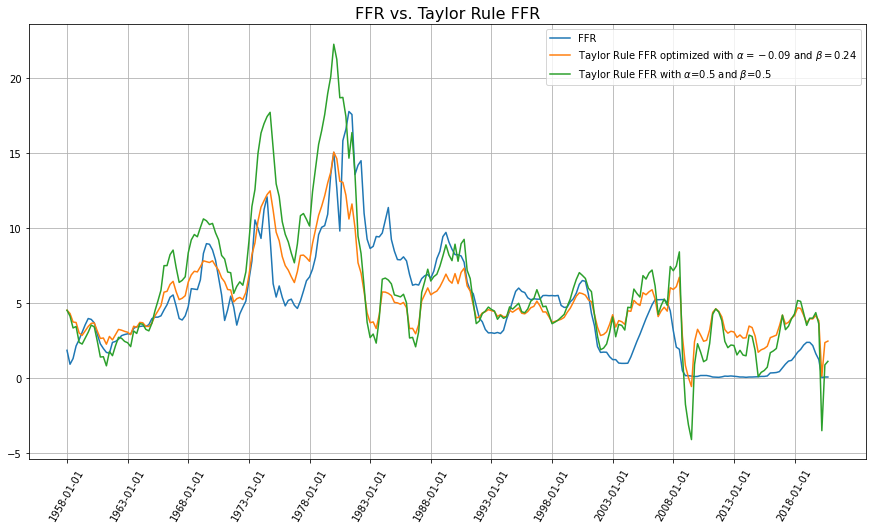

In [40]:
taylor_rule_preds = taylor_rule(2, macroeconomics.loc[:, "CPIAUCSL_pc1"], 2, 
                                macroeconomics.loc[:, "GDPC1_lin"], potential_gdp.loc[:, "GDPPOT"], 
                                alpha=alpha, beta=beta)
taylor_rule_preds_basic = taylor_rule(2, macroeconomics.loc[:, "CPIAUCSL_pc1"], 2, 
                                      macroeconomics.loc[:, "GDPC1_lin"], potential_gdp.loc[:, "GDPPOT"], 
                                      alpha=0.5, beta=0.5)

plt.figure(figsize=(15, 8))
plt.plot(macroeconomics["DATE"], macroeconomics["DFF_lin"], label="FFR")
plt.plot(taylor_rule_preds, label=fr"Taylor Rule FFR optimized with $\alpha={np.round(alpha, 2)}$ and $\beta={np.round(beta, 2)}$")
plt.plot(taylor_rule_preds_basic, label=r"Taylor Rule FFR with $\alpha$=0.5 and $\beta$=0.5")
plt.xticks(rotation=45)
plt.xticks(np.arange(0, ffr.shape[0], 20), rotation=60)
plt.legend()
plt.grid()
plt.title("FFR vs. Taylor Rule FFR", fontsize=16)
plt.show();